# Imports

In [1]:
import pandas as pd

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os

%matplotlib inline

In [3]:
import instaloader

In [4]:
import glob
from PIL import Image
import xlsxwriter
import os

In [5]:
import time as t

In [6]:
import colorsys as cs

In [37]:
import math

# Instagram image extraction + image analysis

#### Instagram image extraction

In [ ]:
L = instaloader.Instaloader()

In [ ]:
#L.login("login","login")

In [ ]:
L = instaloader.Instaloader(download_videos = False,
                            download_video_thumbnails = False,
                            download_geotags = False,
                            download_comments = False,
                            save_metadata = False,
                            post_metadata_txt_pattern = "")
profile = instaloader.Profile.from_username(L.context, "thylacine_music").get_posts()

In [ ]:
for post in profile:
    L.download_post(post, "thylacine_music")

#### Image analysis functions

In [7]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [8]:
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [9]:
def get_colors(image, number_of_colors, show_chart):
    
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)

    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]
    
    index_max_RGB = list(counts.values()).index(max(list(counts.values())))
    max_RGB = list(rgb_colors[index_max_RGB])
    
    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return max_RGB

#### For loop: Excel creation + image analysis

In [86]:
#Start timer
start = t.time()

#Put all images of an Instagram page in an Excel file
images=glob.glob("thylacine_music/*.jpg")
workbook = xlsxwriter.Workbook('images.xlsx')
worksheet = workbook.add_worksheet()
worksheet.set_column('A:B', 15)
worksheet.set_row(1, 70)
bold = workbook.add_format({'bold': True})

worksheet.write('A1', 'Image', bold)
worksheet.write('B1', 'R', bold)
worksheet.write('C1', 'G', bold)
worksheet.write('D1', 'B', bold)

i=2
for image in images:
    with Image.open(image) as img:
        width_100 = img.width
        height_100 = img.height
    width_30 = int(round(width_100 * 0.1, 0))
    img = Image.open(image)
    wpercent = (width_30/float(width_100))
    hsize = int((float(height_100)*float(wpercent)))
    img = img.resize((width_30,hsize), Image.ANTIALIAS)
    img_name = 'local'+str(i)+'.jpg'
    img.save(img_name)
    worksheet.set_row(i-1, hsize)
    worksheet.insert_image('A'+str(i), img_name)
    
    #Image analysis, get max RGB value and input in excel file
    max_RGB = get_colors(get_image(img_name), 3, False)
    worksheet.write('B'+str(i), max_RGB[0])
    worksheet.write('C'+str(i), max_RGB[1])
    worksheet.write('D'+str(i), max_RGB[2])
    
    i=i+1
    #break
    
workbook.close()

#Delete all images in file directory because temp images were created
for image in glob.glob("*.jpg"):
    os.remove(image)

#End timer
end = t.time()

#Duration timer
duration = end - start
if duration > 60:
    minutes = int(duration/60)
    seconds = int(duration - int(duration/60)*60)
    if minutes == 1:
        print("The code lasted", minutes, "minute and", seconds, "seconds.")
    else:
        print("The code lasted", minutes, "minutes and", seconds, "seconds.")
else:
    print("The code lasted", int(duration), "seconds.")

In [10]:
data = pd.read_excel('images.xlsx')

In [11]:
data.head()

,Image,R,G,B
0,NaN,158.629068,129.261377,116.829537
1,NaN,65.278938,65.278938,65.278938
2,NaN,146.987046,145.668398,144.727876
3,NaN,196.360404,123.042519,80.974598
4,NaN,137.868637,119.383536,108.627504


In [12]:
def round_to_tenth(n):
    rem = n % 10
    if rem < 5:
        n = int(n / 10) * 10
    else:
        n = int((n + 10) / 10) * 10
    return n

In [13]:
data['H'] = 0
data['S'] = 0
data['L'] = 0
data['HSL'] = 0
for i in range(0,len(data)):
    data['H'].loc[i] = round_to_tenth(cs.rgb_to_hls(data['R'].loc[i]/255,data['G'].loc[i]/255,data['B'].loc[i]/255)[0]*360)
    data['S'].loc[i] = round_to_tenth(cs.rgb_to_hls(data['R'].loc[i]/255,data['G'].loc[i]/255,data['B'].loc[i]/255)[2]*100)
    data['L'].loc[i] = round_to_tenth(cs.rgb_to_hls(data['R'].loc[i]/255,data['G'].loc[i]/255,data['B'].loc[i]/255)[1]*100)
    data['HSL'].loc[i] = str(data['H'].loc[i]),str(data['S'].loc[i]),str(data['L'].loc[i])
    
    

/Users/salim/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
data

,Image,R,G,B,H,S,L,HSL
0,NaN,158.629068,129.261377,116.829537,20,20,50,"(20, 20, 50)"
1,NaN,65.278938,65.278938,65.278938,0,0,30,"(0, 0, 30)"
2,NaN,146.987046,145.668398,144.727876,20,0,60,"(20, 0, 60)"
3,NaN,196.360404,123.042519,80.974598,20,50,50,"(20, 50, 50)"
4,NaN,137.868637,119.383536,108.627504,20,10,50,"(20, 10, 50)"
...,...,...,...,...,...,...,...,...
307,NaN,245.898512,245.898512,245.898512,0,0,100,"(0, 0, 100)"
308,NaN,16.158646,16.158646,16.158646,0,0,10,"(0, 0, 10)"
309,NaN,37.138278,33.246897,33.742346,350,10,10,"(350, 10, 10)"
310,NaN,73.790499,134.965712,146.385629,190,30,40,"(190, 30, 40)"


In [15]:
data['HSL'].value_counts().head(20)

(0, 0, 0)        12
(0, 0, 10)       11
(30, 30, 70)      4
(30, 10, 50)      4
(20, 20, 50)      4
(20, 20, 10)      3
(40, 10, 70)      3
(20, 10, 20)      3
(30, 20, 10)      3
(300, 10, 20)     3
(70, 10, 40)      3
(250, 20, 10)     3
(20, 30, 20)      2
(20, 10, 10)      2
(330, 0, 20)      2
(0, 0, 90)        2
(20, 0, 10)       2
(30, 20, 60)      2
(10, 20, 50)      2
(40, 10, 10)      2
Name: HSL, dtype: int64

In [16]:
data['HSL'].nunique()

236

In [38]:
tuple([math.trunc(255*x) for x in cs.hls_to_rgb(data['H'].loc[0]/360, data['L'].loc[0]/100, data['S'].loc[0]/100)])

(153, 119, 102)

In [75]:
def hsl_to_rgb(a,b,c):
    value = tuple([round(x,2) for x in cs.hls_to_rgb(a/360, b/100, c/100)])
    return value

In [76]:
data['RGB rework'] = 'test'

for i in range(0,len(data)):
    data['RGB rework'].loc[i] = hsl_to_rgb(data['H'].loc[i],data['L'].loc[i],data['S'].loc[i])

In [77]:
data

,Image,R,G,B,H,S,L,HSL,RGB rework
0,NaN,158.629068,129.261377,116.829537,20,20,50,"(20, 20, 50)","(0.6, 0.47, 0.4)"
1,NaN,65.278938,65.278938,65.278938,0,0,30,"(0, 0, 30)","(0.3, 0.3, 0.3)"
2,NaN,146.987046,145.668398,144.727876,20,0,60,"(20, 0, 60)","(0.6, 0.6, 0.6)"
3,NaN,196.360404,123.042519,80.974598,20,50,50,"(20, 50, 50)","(0.75, 0.42, 0.25)"
4,NaN,137.868637,119.383536,108.627504,20,10,50,"(20, 10, 50)","(0.55, 0.48, 0.45)"
...,...,...,...,...,...,...,...,...,...
307,NaN,245.898512,245.898512,245.898512,0,0,100,"(0, 0, 100)","(1.0, 1.0, 1.0)"
308,NaN,16.158646,16.158646,16.158646,0,0,10,"(0, 0, 10)","(0.1, 0.1, 0.1)"
309,NaN,37.138278,33.246897,33.742346,350,10,10,"(350, 10, 10)","(0.11, 0.09, 0.09)"
310,NaN,73.790499,134.965712,146.385629,190,30,40,"(190, 30, 40)","(0.28, 0.48, 0.52)"


In [86]:
data['RGB rework'].value_counts()

(0.0, 0.0, 0.0)       22
(0.1, 0.1, 0.1)       21
(0.2, 0.2, 0.2)       10
(0.8, 0.8, 0.8)        8
(0.7, 0.7, 0.7)        7
                      ..
(0.73, 0.73, 0.67)     1
(0.22, 0.18, 0.18)     1
(0.76, 0.7, 0.64)      1
(0.33, 0.3, 0.27)      1
(0.71, 0.67, 0.73)     1
Name: RGB rework, Length: 174, dtype: int64

In [92]:
data_color_count = pd.DataFrame(data['RGB rework'].value_counts()).reset_index()
data_color_count.columns = ['RGB colors', 'Count']

In [93]:
data_color_count

,RGB colors,Count
0,"(0.0, 0.0, 0.0)",22
1,"(0.1, 0.1, 0.1)",21
2,"(0.2, 0.2, 0.2)",10
3,"(0.8, 0.8, 0.8)",8
4,"(0.7, 0.7, 0.7)",7
...,...,...
169,"(0.73, 0.73, 0.67)",1
170,"(0.22, 0.18, 0.18)",1
171,"(0.76, 0.7, 0.64)",1
172,"(0.33, 0.3, 0.27)",1


In [95]:
list(data_color_count['RGB colors'].head(20))

[(0.0, 0.0, 0.0),
 (0.1, 0.1, 0.1),
 (0.2, 0.2, 0.2),
 (0.8, 0.8, 0.8),
 (0.7, 0.7, 0.7),
 (0.11, 0.1, 0.09),
 (0.79, 0.7, 0.61),
 (0.11, 0.09, 0.09),
 (0.12, 0.09, 0.08),
 (0.22, 0.19, 0.18),
 (0.55, 0.5, 0.45),
 (0.6, 0.47, 0.4),
 (0.09, 0.1, 0.11),
 (0.6, 0.6, 0.6),
 (0.5, 0.5, 0.5),
 (0.19, 0.18, 0.22),
 (1.0, 1.0, 1.0),
 (0.36, 0.24, 0.24),
 (0.73, 0.71, 0.67),
 (0.09, 0.08, 0.12)]

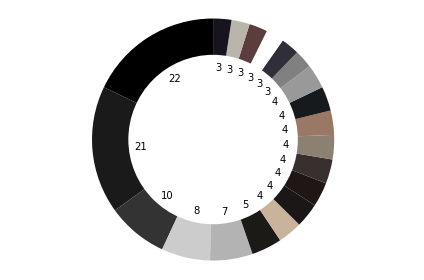

In [96]:
# Pie chart
sizes = list(data_color_count['Count'].head(20))
#colors
colors = list(data_color_count['RGB colors'].head(20))
fig1, ax1 = plt.subplots()

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(p=pct,v=val)
    return my_autopct

ax1.pie(sizes, colors = colors, autopct=make_autopct(sizes), startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

# Image analysis

In [5]:
image = cv2.imread('2020-09-18_15-36-48_UTC_1.jpg')

In [6]:
image.shape

(1080, 1080, 3)

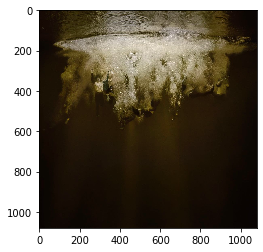

In [7]:
plt.imshow(image)

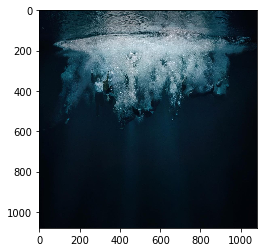

In [8]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [75]:
max_RGB = get_colors(get_image('2019-12-29_13-41-57_UTC.jpg'), 3, False)

In [77]:
max_RGB[0]

210.02035482207847

In [131]:
def rgb_to_hsl(r, g, b):
    r = float(r)
    g = float(g)
    b = float(b)
    high = max(r, g, b)
    low = min(r, g, b)
    h, s, v = ((high + low) / 2,)*3

    if high == low:
        h = 0.0
        s = 0.0
    else:
        d = high - low
        s = d / (2 - high - low) if v > 0.5 else d / (high + low)
        h = {
            r: (g - b) / d + (6 if g < b else 0),
            g: (b - r) / d + 2,
            b: (r - g) / d + 4,
        }[high]
        h /= 6

    return h, s, v

In [ ]:
for i in get_colors(get_image('2020-11-27_12-36-16_UTC_2.jpg'), 3, True):
    print(i)

In [ ]:
imgHLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

In [ ]:
import colorsys

In [ ]:
hlsval = colorsys.rgb_to_hls(get_colors(get_image('2020-11-27_12-36-16_UTC_2.jpg'), 3, True)[0][0],get_colors(get_image('2020-11-27_12-36-16_UTC_2.jpg'), 3, True)[0][1],get_colors(get_image('2020-11-27_12-36-16_UTC_2.jpg'), 3, True)[0][2])

In [ ]:
print(hlsval)

In [ ]:
def get_colors(image, number_of_colors, show_chart):
    
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    print(counts)
    print(counts.items())
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    print(counts)
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]
    print(center_colors)
    print(counts)
    print(counts.keys)
    print(counts.values())
    print(list(counts.values()).index(max(list(counts.values()))))
    print(rgb_colors[list(counts.values()).index(max(list(counts.values())))])
    print(ordered_colors)
    print(hex_colors)
    print(rgb_colors)
    
    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return rgb_colors

In [124]:
import colorsys as cs

In [137]:
cs.rgb_to_hls(196/255,123/255,80/255)

(0.0617816091954023, 0.5411764705882354, 0.49572649572649574)

In [142]:
0.06*360

21.599999999999998

In [136]:
rgb_to_hsl(196.3604038/255,123.0425191/255,80.97459823/255)

(0.060764147811461174, 0.4959310879450717, 0.543794121627451)